In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# run params
SECTION = 'gan'
RUN_ID = '0003'
DATA_NAME = 'celeb'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #
DATA_FOLDER = './data/celeb/'

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 64

In [4]:
NUM_CLASSES = 10
BATCH_SIZE = 64
transform = transforms.Compose([   
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)


class SimpleDataset(Dataset):
    def __init__(self, filenames, transform):
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img = Image.open(self.filenames[idx])
        if self.transform:
            img = self.transform(img)
        return img

In [5]:
dataset = SimpleDataset(filenames, transform)
dataloader = DataLoader(dataset, BATCH_SIZE,drop_last = True)
z_dim = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
class Critic(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, 2)
        self.conv2 = nn.Conv2d(64, 128, 5, 2)

        self.conv3 = nn.Conv2d(128, 256, 5, 2)
        self.conv4 = nn.Conv2d(256, 512, 5, 2)

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(8192, 1)
    
    def forward(self, x):
        x = F.pad(x, (2, 2, 2, 2))
        x = self.conv1(x)
        x = F.leaky_relu(x)

        x = F.pad(x, (2, 2, 2, 2))
        x = self.conv2(x)
        x = F.leaky_relu(x)

        x = F.pad(x, (2, 2, 2, 2))
        x = self.conv3(x)
        x = F.leaky_relu(x)

        x = F.pad(x, (2, 2, 2, 2))
        x = self.conv4(x)
        x = F.leaky_relu(x)
        # print(x.shape)
        x = self.flatten(x)
        x = self.linear1(x)

        return x

In [7]:
z_dim = 100
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.linear1 = nn.Linear(z_dim, 8192)
        self.bn1 = nn.BatchNorm1d(8192, momentum=0.9)

        self.convT1 = nn.ConvTranspose2d(512, 256, 5, 2, 2)
        self.bn2 = nn.BatchNorm2d(256, momentum=0.9)

        self.convT2 = nn.ConvTranspose2d(256, 128, 5, 2, 2)
        self.bn3 = nn.BatchNorm2d(128, momentum=0.9)

        self.convT3 = nn.ConvTranspose2d(128, 64, 5, 2, 2)
        self.bn4 = nn.BatchNorm2d(64, momentum=0.9)
        self.convT4 = nn.ConvTranspose2d(64, 3, 4, 2, 1)

        
    def forward(self, x):
        x = self.bn1(self.linear1(x))
        x = F.leaky_relu(x)
        x = x.reshape(-1, 512, 4, 4)

        x = F.pad(self.convT1(x), (0, 1, 0, 1))
        x = self.bn2(x)
        x = F.leaky_relu(x)

        x = F.pad(self.convT2(x), (0, 1, 0, 1))
        x = F.leaky_relu(self.bn3(x))

        x = F.pad(self.convT3(x), (0, 1, 0, 1))
        x = F.leaky_relu(self.bn4(x))
        # x = F.pad(x, (1, 1, 1, 1))
        x = self.convT4(x)
        return torch.tanh(x)

In [8]:
critic = Critic().to(device)
generator =  Generator(100).to(device)
d_optimizer = optim.Adam(critic.parameters(),lr=0.00005)
g_optimizer = optim.Adam(generator.parameters(), lr=0.00005)

In [9]:
def gradient_penalty(real_images, fake_images, critic):
    """ Calculates the gradient penalty.
    This loss is calculated on an interpolated image
    and added to the discriminator loss.
    """
    epsilon = torch.randn(real_images.shape[0], 1, 1, 1).to(device)
    x_hat = epsilon * real_images + (1 - epsilon) * fake_images
    t = critic(x_hat)
    x_hat = (torch.sum(x_hat.square(),dim=1).sqrt() - 1).square()
    return x_hat.mean()

In [10]:
n_critic = 5
d_losses, g_losses = [], []
for epoch in range(5):  # loop over the dataset multiple times
    g_total, d_total = 0., 0.
    for i, inputs in enumerate(dataloader, 0):
        inputs = inputs.to(device)

        for _ in range(n_critic):
            generator.eval()
            generated_images = generator(torch.randn((BATCH_SIZE, z_dim)).to(device))
            
            gp = gradient_penalty(inputs, generated_images, critic)
            d_loss = - torch.mean(critic(generated_images))
            
            d_loss += torch.mean(critic(inputs))
            
            
            d_loss += gp


            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

        generator.train()
        critic.eval()
        real = torch.ones((BATCH_SIZE, 1)).to(device)
        generated_images = generator(torch.randn((BATCH_SIZE, z_dim)).to(device))

        g_loss = - torch.mean(critic(generated_images))
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        d_total += d_loss.item()
        g_total += g_loss.item()
    
    d_losses.append(d_total/len(dataloader))
    g_losses.append(g_total/len(dataloader))

    print(f'[{epoch + 1}] d_loss: {d_total / len(dataloader):.3f} g_loss: {g_total / len(dataloader):.3f}')
    torch.save(critic, RUN_FOLDER + "/weights/critic.pt")
    torch.save(generator, RUN_FOLDER + "/weights/generator.pt")


print('Finished Training')

[1] d_loss: -6839685033875.797 g_loss: -195819906168.818


KeyboardInterrupt: 

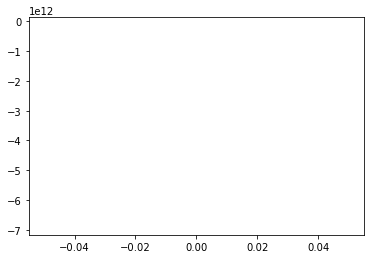

In [11]:
fig = plt.figure()
plt.plot([x for x in d_losses], color='red', linewidth=1)

plt.plot([y for y in g_losses], color='orange', linewidth=1)

plt.show()
